In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/Hermes"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.simple_synthetic_array_beamformer_processor_multiFrame import SyntheticArrayBeamformerProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data_simple_multiframe import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data_simple_multiframe import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

print(cfg_manager.range_res_m)
print(cfg_manager.range_max_m)
print(cfg_manager.profile_cfgs)
print(cfg_manager.frameCfg_loops)

0.13657211975555555
12.291490778
[{'profileId': 0, 'startFreq_GHz': 77.0, 'idleTime_us': 300.0, 'adcStartTime_us': 7.0, 'rampEndTime_us': 100.0, 'txOutPower': 0.0, 'txPhaseShifter': 0.0, 'freqSlope_MHz_us': 25.0, 'txStartTime_us': 1.0, 'adcSamples': 90, 'sampleRate_kSps': 2050, 'hpfCornerFreq1': 0, 'hpfCornerFreq2': 0, 'rxGain_dB': 30.0}]
100


In [3]:
#load the dataset
dataset_name = "hermes_north_vicon_1"#"cpsl_radvel_test_1_sar_flight_2"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

found 1065 radar samples
found 1065 lidar samples
did not find camera samples
did not find hand tracking samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 1065 vehicle velocity samples
found 1065 vehicle odometry samples


In [4]:
processor = SyntheticArrayBeamformerProcessor(
    config_manager=cfg_manager,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-90,stop=90,num=90
                 )),
    el_angle_bins_rad=np.array([0]),
    chirp_cfg_idx=0,
    num_frames=5, #10
    stride=1,
    receiver_idx = 0,
    min_vel=np.array([0.00,0.30,0.0]),
    max_vel=np.array([0.05,0.70,0.05]), #np.array([0.05,0.50,0.05]),
    max_vel_stdev=np.array([0.02,0.02,0.02]), #np.array([0.02,0.02,0.02]),
    enable_calibration=False,
    num_calibration_iters=1
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    processor_SABF=processor,
    min_vel=0.2,
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor,
    temp_dir_path=os.path.join("~/Downloads/syntheticArraysProc",dataset_name)
)

found temp dir: /home/david/Downloads/syntheticArraysProc/hermes_north_vicon_1
clearing temp directory /home/david/Downloads/syntheticArraysProc/hermes_north_vicon_1


In [5]:
idx = 0
while not processor.array_geometry_valid:

    #get vel_data
    vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])

    #get adc data
    adc_cube = dataset.get_radar_data(idx)

    #process the data
    processor.process(adc_cube,ned_vel_data)
    idx += 1

    if idx >= dataset.num_frames:
        print("No valid array geometry found in dataset")
        break


print(idx - 1)
first_frame_idx = idx - 1

193


In [6]:
# speed test
for i in tqdm(range(200)):

    #compute the synthetic response
    beamformed_response = processor.compute_synthetic_response(processor.array_geometry)

    if processor.enable_calibration:
        for _ in range(processor.num_calibration_iters):
            new_array_geometry = processor.perform_array_calibration()
            if new_array_geometry.shape[0] != 0:
                beamformed_response = processor.compute_synthetic_response(
                    processor.array_geometry_calibrated
                )
            else:
                processor.array_geometry_calibrated = processor.array_geometry
                break


100%|██████████| 200/200 [00:01<00:00, 156.33it/s]


In [7]:
valid_idxs = []

#pre-load the processor
for i in range(dataset.num_frames):
    #get vel_data
    vel_data = np.mean(dataset.get_vehicle_odom_data(i)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])

    #get adc data
    adc_cube = dataset.get_radar_data(i)

    #process the data
    processor.process(adc_cube,ned_vel_data)
    
    if processor.array_geometry_valid:
        valid_idxs.append(i)

print(valid_idxs)

[193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 459, 470, 471, 472, 473, 474, 602, 603, 604, 635, 645, 646, 647, 648, 649, 662, 663, 664, 665, 754, 841, 842, 851, 853, 854, 855, 856, 857, 858]


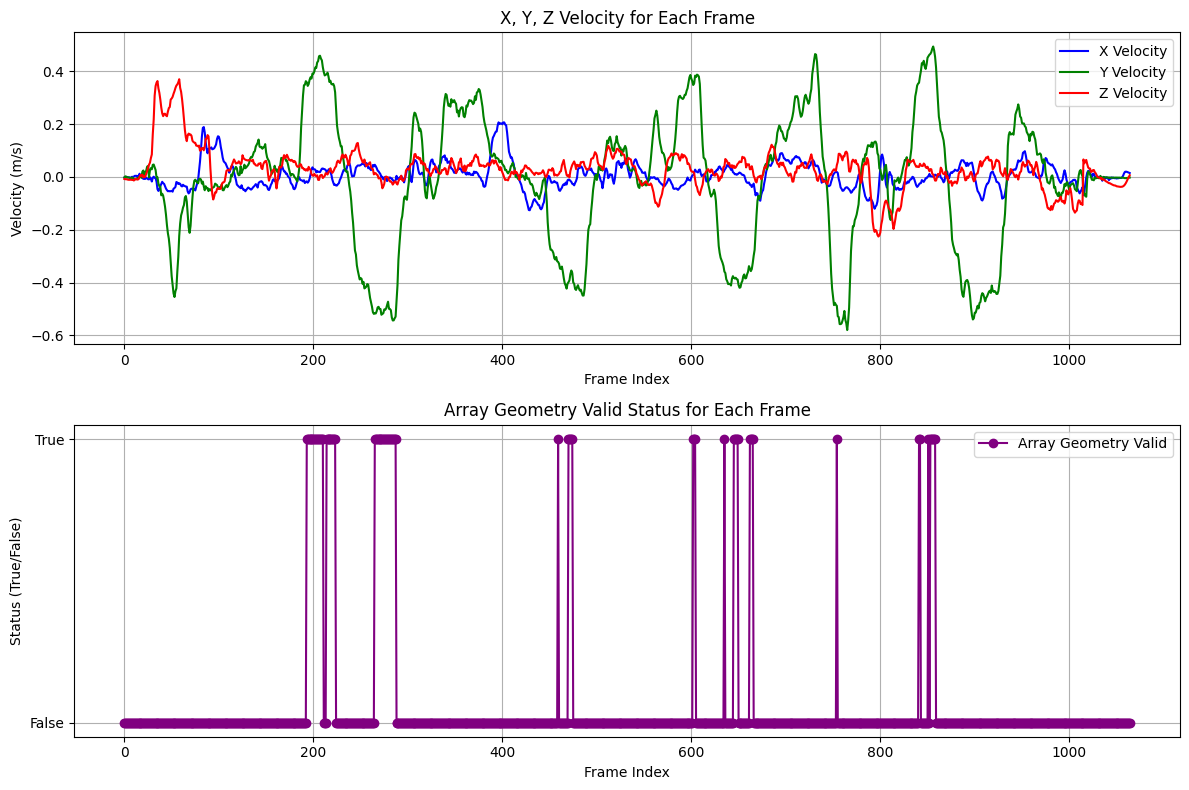

In [8]:
valid_idxs = []
vel_history = []
array_geometry_status = []

# Pre-load the processor
for i in range(dataset.num_frames):
    # Get velocity data
    vel_data = np.mean(dataset.get_vehicle_odom_data(i)[:, 8:11], axis=0)
    # Convert into NED
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])
    vel_history.append(ned_vel_data)

    # Get ADC data
    adc_cube = dataset.get_radar_data(i)

    # Process the data
    processor.process(adc_cube, ned_vel_data)

    # Store array geometry status
    array_geometry_status.append(processor.array_geometry_valid)

    if processor.array_geometry_valid:
        valid_idxs.append(i)

# Convert velocity history and array geometry status to numpy arrays
vel_history = np.array(vel_history)
array_geometry_status = np.array(array_geometry_status)

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: X, Y, Z velocity for each frame
axs[0].plot(vel_history[:, 0], label="X Velocity", color="blue")
axs[0].plot(vel_history[:, 1], label="Y Velocity", color="green")
axs[0].plot(vel_history[:, 2], label="Z Velocity", color="red")
axs[0].set_title("X, Y, Z Velocity for Each Frame")
axs[0].set_xlabel("Frame Index")
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Array geometry valid status for each frame
axs[1].plot(array_geometry_status, label="Array Geometry Valid", color="purple", marker="o")
axs[1].set_title("Array Geometry Valid Status for Each Frame")
axs[1].set_xlabel("Frame Index")
axs[1].set_ylabel("Status (True/False)")
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(["False", "True"])
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



/home/david/Documents/mmwave_radar_processing/mmwave_radar_processing/plotting/plotter_synthetic_array_data_simple_multiframe.py:280: RuntimeWarning: divide by zero encountered in log10
  resp = 20 * np.log10(np.abs(resp))


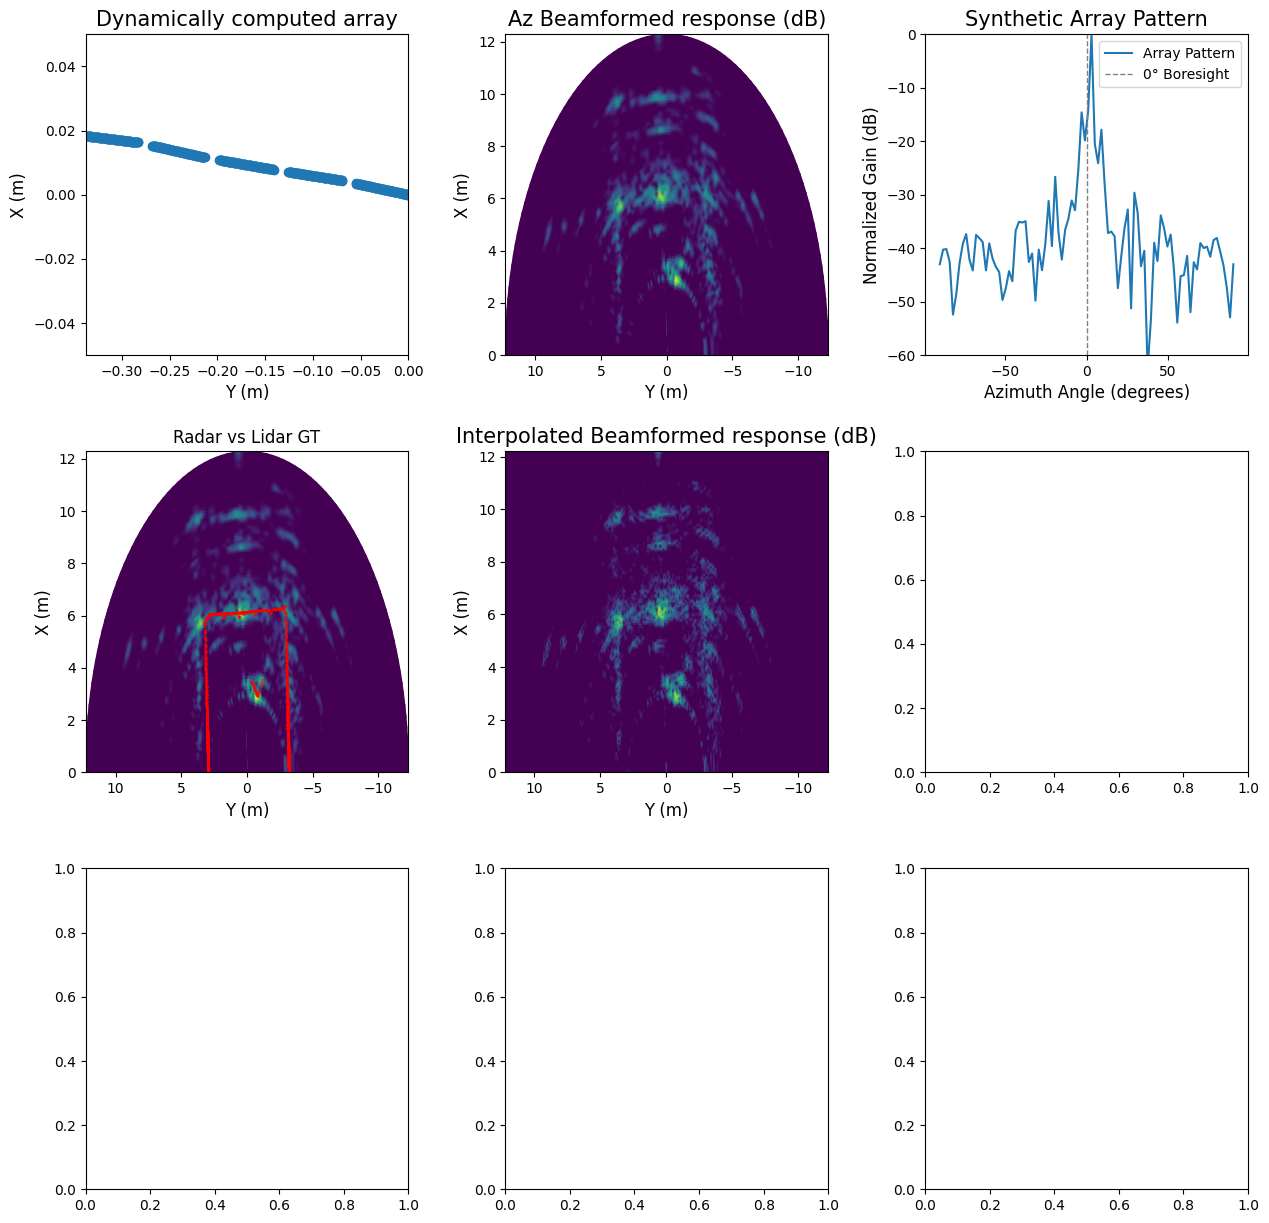

In [9]:
#get the velocity of the vehicle
# idx = first_frame_idx
# idx = valid_idxs[7]
idx = valid_idxs[1]


#pre-load the processor
for i in range(idx):
    #get vel_data
    vel_data = np.mean(dataset.get_vehicle_odom_data(i)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])

    #get adc data
    adc_cube = dataset.get_radar_data(i)

    #process the data
    processor.process(adc_cube,ned_vel_data)

#get the velocity data
vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
ned_vel_data = np.array([
    vel_data[0],
    vel_data[1],
    vel_data[2]
])

#get the adc cube
adc_cube = dataset.get_radar_data(idx)


#get the lidar pointcloud for gt comparison
try:
    lidar_pc_raw = dataset.get_lidar_point_cloud_raw(idx)
except AssertionError:
    lidar_pc_raw = np.empty(shape=(0))

try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

synthetic_array_plotter.plot_compilation(
    adc_cube=adc_cube,
    vels=ned_vel_data,
    camera_view=camera_view,
    lidar_pc_raw=lidar_pc_raw,
    lidar_radar_offset_rad=np.deg2rad(0), #90 for front, 270 for back
    convert_to_dB=True,
    cmap="viridis",
    show=True
)

# print(f"vel_data: \n{processor.history_avg_vel}")
# print(f"ned_vel_data: {ned_vel_data}")

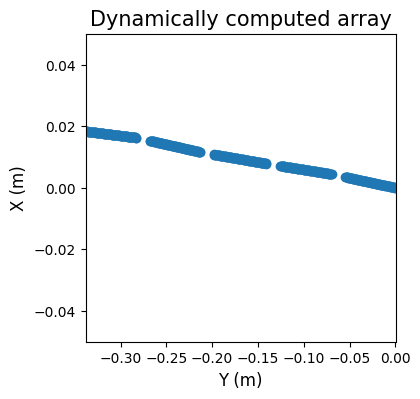

In [16]:
fig,ax = plt.subplots(figsize=(4,4))
synthetic_array_plotter.plot_synthetic_array_geometry(
    vels=vel_data,
    ax=ax,
    show=True
)

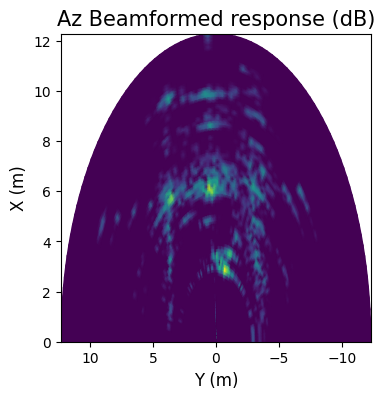

In [15]:
fig,ax = plt.subplots(figsize=(4,4))
synthetic_array_plotter.plot_2D_az_beamformed_resp_slice(
    resp=processor.beamformed_resp,
    convert_to_dB=True,
    ax=ax,
    show=True
)

In [ ]:
interp_x = processor.interp_x_s
interp_y = processor.interp_y_s

# Print the min and max of the grids
print(f"interp_x: min={interp_x.min()}, max={interp_x.max()}")
print(f"interp_y: min={interp_y.min()}, max={interp_y.max()}")

print(processor.interpolated_beamformed_resp.shape)

interp_x: min=0.0, max=12.200000000000001
interp_y: min=-12.291490778, max=12.208509221999915
(123, 246)


  0%|          | 0/852 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:02<00:00, 15.67it/s]


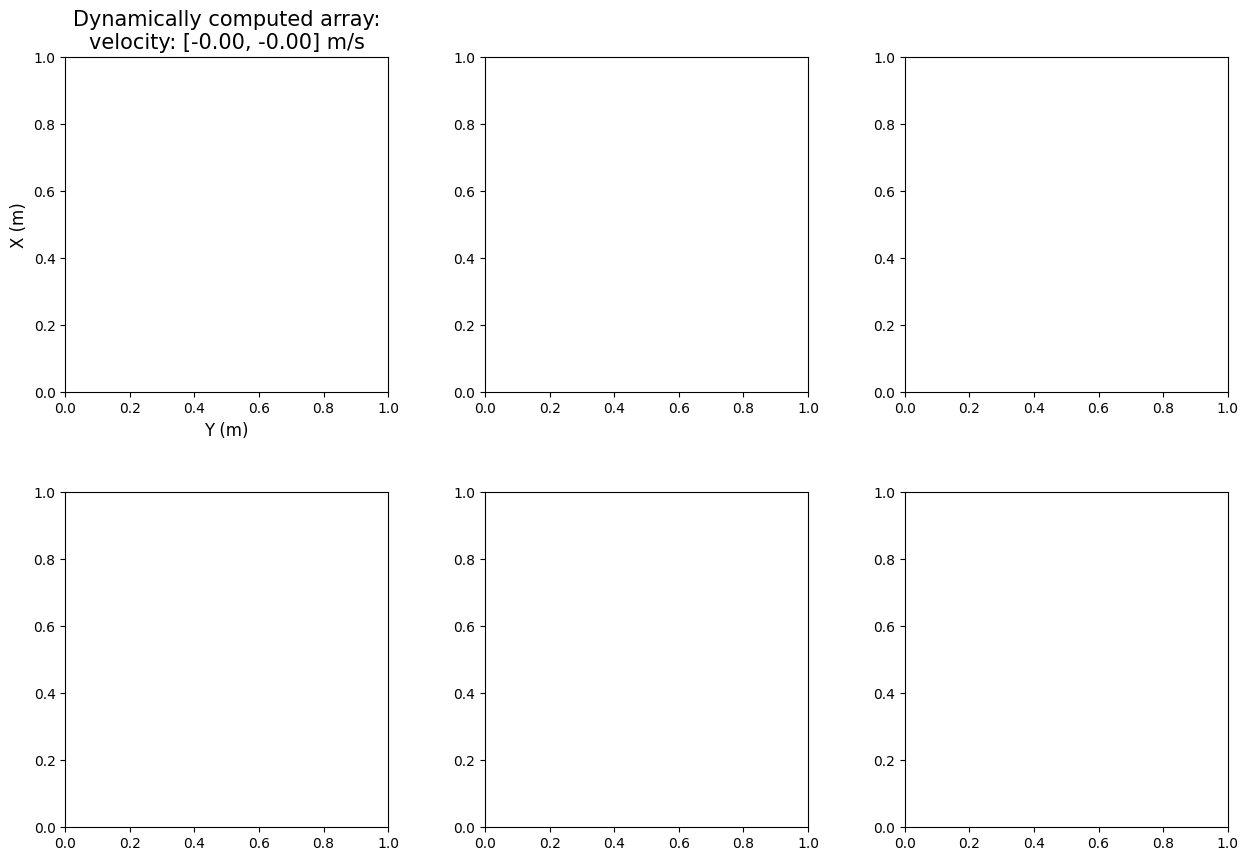

In [ ]:
#generate the movie
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True,
    lidar_radar_offset_rad=np.deg2rad(90)
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_uav.mp4".format(dataset_name),fps=fps)

In [ ]:
import numpy as np
from scipy.interpolate import griddata

def map_to_linear_grid(x_s, y_s, z_s, response, grid_resolution=0.1, value_range=None):
    """
    Map the spherical grid and response to a linear grid using interpolation.

    Args:
        x_s (np.ndarray): x-coordinates of the spherical grid.
        y_s (np.ndarray): y-coordinates of the spherical grid.
        z_s (np.ndarray): z-coordinates of the spherical grid.
        response (np.ndarray): Beamformed response indexed by [rho, theta, phi].
        grid_resolution (float): Resolution of the linear grid.
        value_range (tuple, optional): Range of values to consider for interpolation (min, max).

    Returns:
        tuple: Linear grid (x, y, z) and the interpolated response.
    """
    # Flatten the spherical grid and response
    x_flat = x_s.flatten()
    y_flat = y_s.flatten()
    z_flat = z_s.flatten()
    response_flat = response.flatten()

    # Define the bounds of the linear grid
    x_min, x_max = np.min(x_flat), np.max(x_flat)
    y_min, y_max = np.min(y_flat), np.max(y_flat)
    z_min, z_max = np.min(z_flat), np.max(z_flat)

    # Create the linear grid
    x_lin = np.arange(x_min, x_max, grid_resolution)
    y_lin = np.arange(y_min, y_max, grid_resolution)
    z_lin = np.arange(z_min, z_max, grid_resolution)
    x_grid, y_grid, z_grid = np.meshgrid(x_lin, y_lin, z_lin, indexing="ij")

    # Interpolate the response onto the linear grid
    points = np.column_stack((x_flat, y_flat, z_flat))  # Original grid points
    grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten(), z_grid.flatten()))  # Linear grid points

    # Apply interpolation
    interpolated_response = griddata(
        points, response_flat, grid_points, method="linear", fill_value=0
    )

    # Reshape the interpolated response to match the linear grid
    interpolated_response = interpolated_response.reshape(x_grid.shape)

    # # Optionally filter values outside the specified range
    # if value_range is not None:
    #     min_val, max_val = value_range
    #     interpolated_response[(interpolated_response < min_val) | (interpolated_response > max_val)] = 0

    return (x_grid, y_grid, z_grid), interpolated_response

def map_to_linear_grid_2D(x_s, y_s, response, grid_resolution=0.1, value_range=None):
    """
    Map the spherical grid and response to a 2D linear grid using interpolation.

    Args:
        x_s (np.ndarray): x-coordinates of the spherical grid.
        y_s (np.ndarray): y-coordinates of the spherical grid.
        response (np.ndarray): Beamformed response indexed by [rho, theta].
        grid_resolution (float): Resolution of the linear grid.
        value_range (tuple, optional): Range of values to consider for interpolation (min, max).

    Returns:
        tuple: Linear grid (x, y) and the interpolated response.
    """
    # Flatten the spherical grid and response
    x_flat = x_s.flatten()
    y_flat = y_s.flatten()
    response_flat = response.flatten()

    # Define the bounds of the linear grid
    x_min, x_max = np.min(x_flat), np.max(x_flat)
    y_min, y_max = np.min(y_flat), np.max(y_flat)

    # Create the linear grid
    x_lin = np.arange(x_min, x_max, grid_resolution)
    y_lin = np.arange(y_min, y_max, grid_resolution)
    x_grid, y_grid = np.meshgrid(x_lin, y_lin, indexing="ij")

    # Interpolate the response onto the linear grid
    points = np.column_stack((x_flat, y_flat))  # Original grid points
    grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))  # Linear grid points

    # Apply interpolation
    interpolated_response = griddata(
        points, response_flat, grid_points, method="linear", fill_value=0
    )

    # Reshape the interpolated response to match the linear grid
    interpolated_response = interpolated_response.reshape(x_grid.shape)

    return (x_grid, y_grid), interpolated_response

x_grid shape: (123, 246)


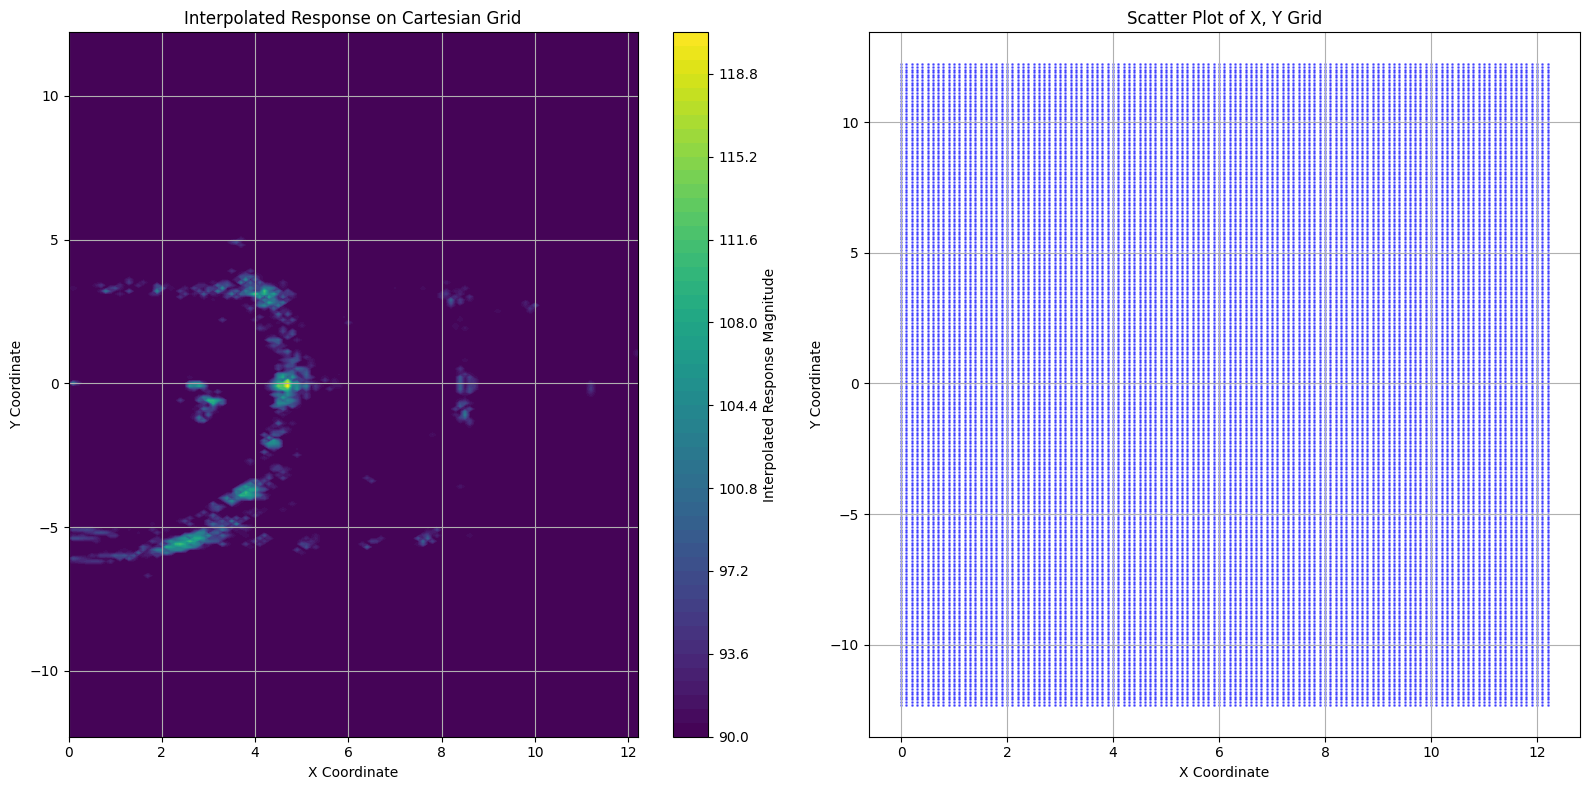

In [ ]:
(x_grid, y_grid), interpolated_response = map_to_linear_grid_2D(
    processor.x_s[:, :, 0],  # Use only the first slice along z-axis
    processor.y_s[:, :, 0],  # Use only the first slice along z-axis
    processor.beamformed_resp[:, :, 0],  # Use only the first slice along z-axis
    grid_resolution=0.1,
    value_range=(0, np.max(processor.beamformed_resp))
)

print(f"x_grid shape: {x_grid.shape}")
resp = 20 * np.log10(np.abs(interpolated_response) + 1e-12)
#remove anything below the min_threshold dB down
thresholded_val = np.max(resp) - 30
idxs = resp <= thresholded_val
resp[idxs] = thresholded_val

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Subplot 1: Contour plot of the interpolated response
contour = axs[0].contourf(x_grid, y_grid, resp, levels=50, cmap="viridis")
fig.colorbar(contour, ax=axs[0], label="Interpolated Response Magnitude")
axs[0].set_title("Interpolated Response on Cartesian Grid")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Y Coordinate")
axs[0].grid(True)

# Subplot 2: Scatter plot of the x, y grid
axs[1].scatter(x_grid.flatten(), y_grid.flatten(), s=1, c="blue", alpha=0.5)
axs[1].set_title("Scatter Plot of X, Y Grid")
axs[1].set_xlabel("X Coordinate")
axs[1].set_ylabel("Y Coordinate")
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


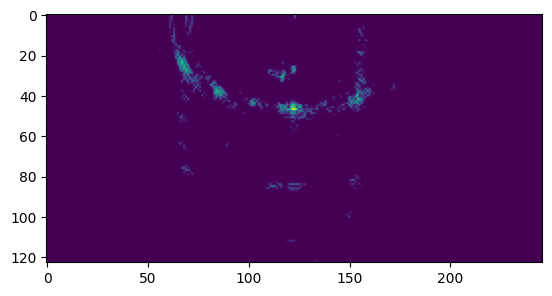

In [ ]:
plt.imshow(resp)

### Looking at the results for the original beamforming technique

In [ ]:
from scipy.signal import find_peaks

#load the reshaped adc cube
adc_cube_reshaped = \
processor.history_acd_cube_valid_chirps.transpose((1,0,2)).reshape(
    processor.history_acd_cube_valid_chirps.shape[1], #number of samples per chirp
    -1
)

#compute the range ffts
window = np.hamming(adc_cube_reshaped.shape[1]).reshape(1, -1)
windowed_signal = window * adc_cube_reshaped
freq_resps = np.fft.fft(windowed_signal,axis=0)

freq_resps_dB = 20 * np.log10(np.abs(freq_resps))

#get the average response
avg_resp = np.mean(20 * np.log10(np.abs(freq_resps)), axis=1)
# Find the peaks using scipy
peak_indices, _ = find_peaks(avg_resp, height=0)  # height=0 ensures we find all peaks
peak_values = avg_resp[peak_indices]

# Sort the peaks by their values in descending order and get the top 5
sorted_peak_indices = peak_indices[np.argsort(peak_values)[-10:][::-1]]
sorted_peak_values = avg_resp[sorted_peak_indices]

print(f"Indices of the 5 highest peaks: {sorted_peak_indices}")
print(f"Values of the 5 highest peaks: {sorted_peak_values}")

Indices of the 5 highest peaks: [37 44 28 40 25 23 47 60 65  5]
Values of the 5 highest peaks: [74.06937969 68.87429848 67.67573281 60.89364832 59.7205839  58.05721212
 57.79543448 57.14635195 56.85489913 55.53500124]


### Looking at the results for a modified beamforming technique

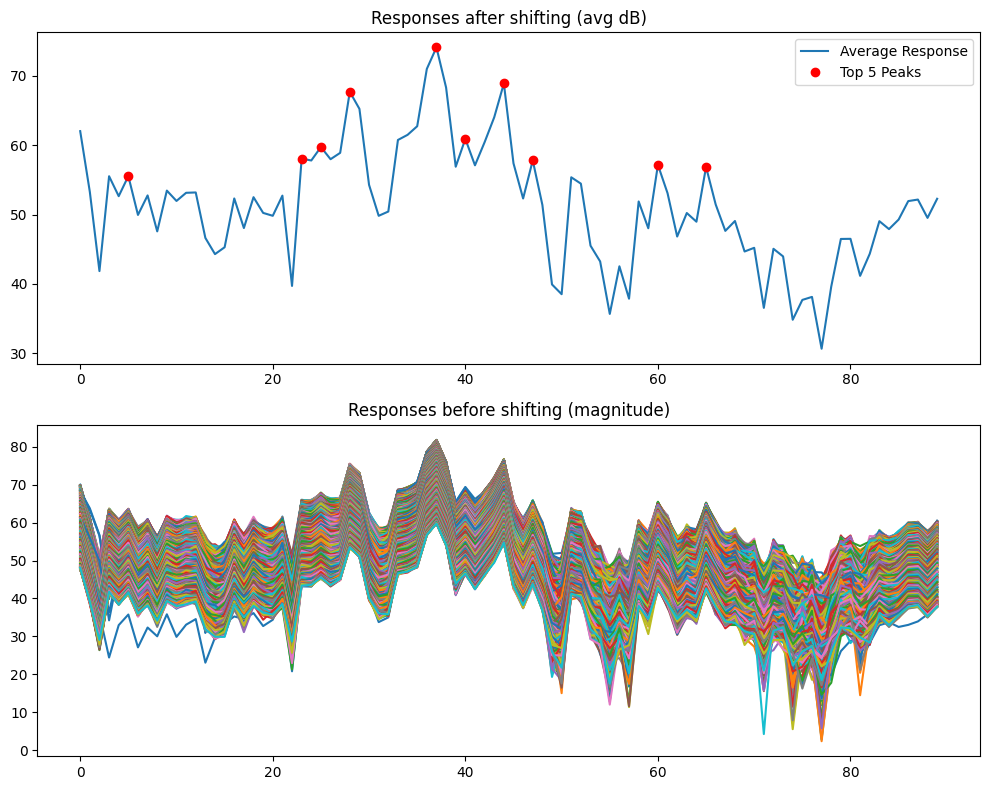

In [ ]:
# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the average response with peaks in the first subplot
axs[0].plot(avg_resp, label="Average Response")
axs[0].plot(sorted_peak_indices, sorted_peak_values, "ro", label="Top 5 Peaks")
axs[0].set_title("Responses after shifting (avg dB)")
axs[0].legend()

# Plot the responses before shifting in the second subplot
axs[1].plot(np.abs(freq_resps_dB))
axs[1].set_title("Responses before shifting (magnitude)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Indices of the top 2 peaks: [12 16]
Values of the top 2 peaks: [56.6140677  52.17113293]
Corresponding azimuth angles (degrees): [-65.73033708 -57.64044944]
array geometry 1st element: [1.55021171e-07 3.67390673e-07 5.54887315e-06]


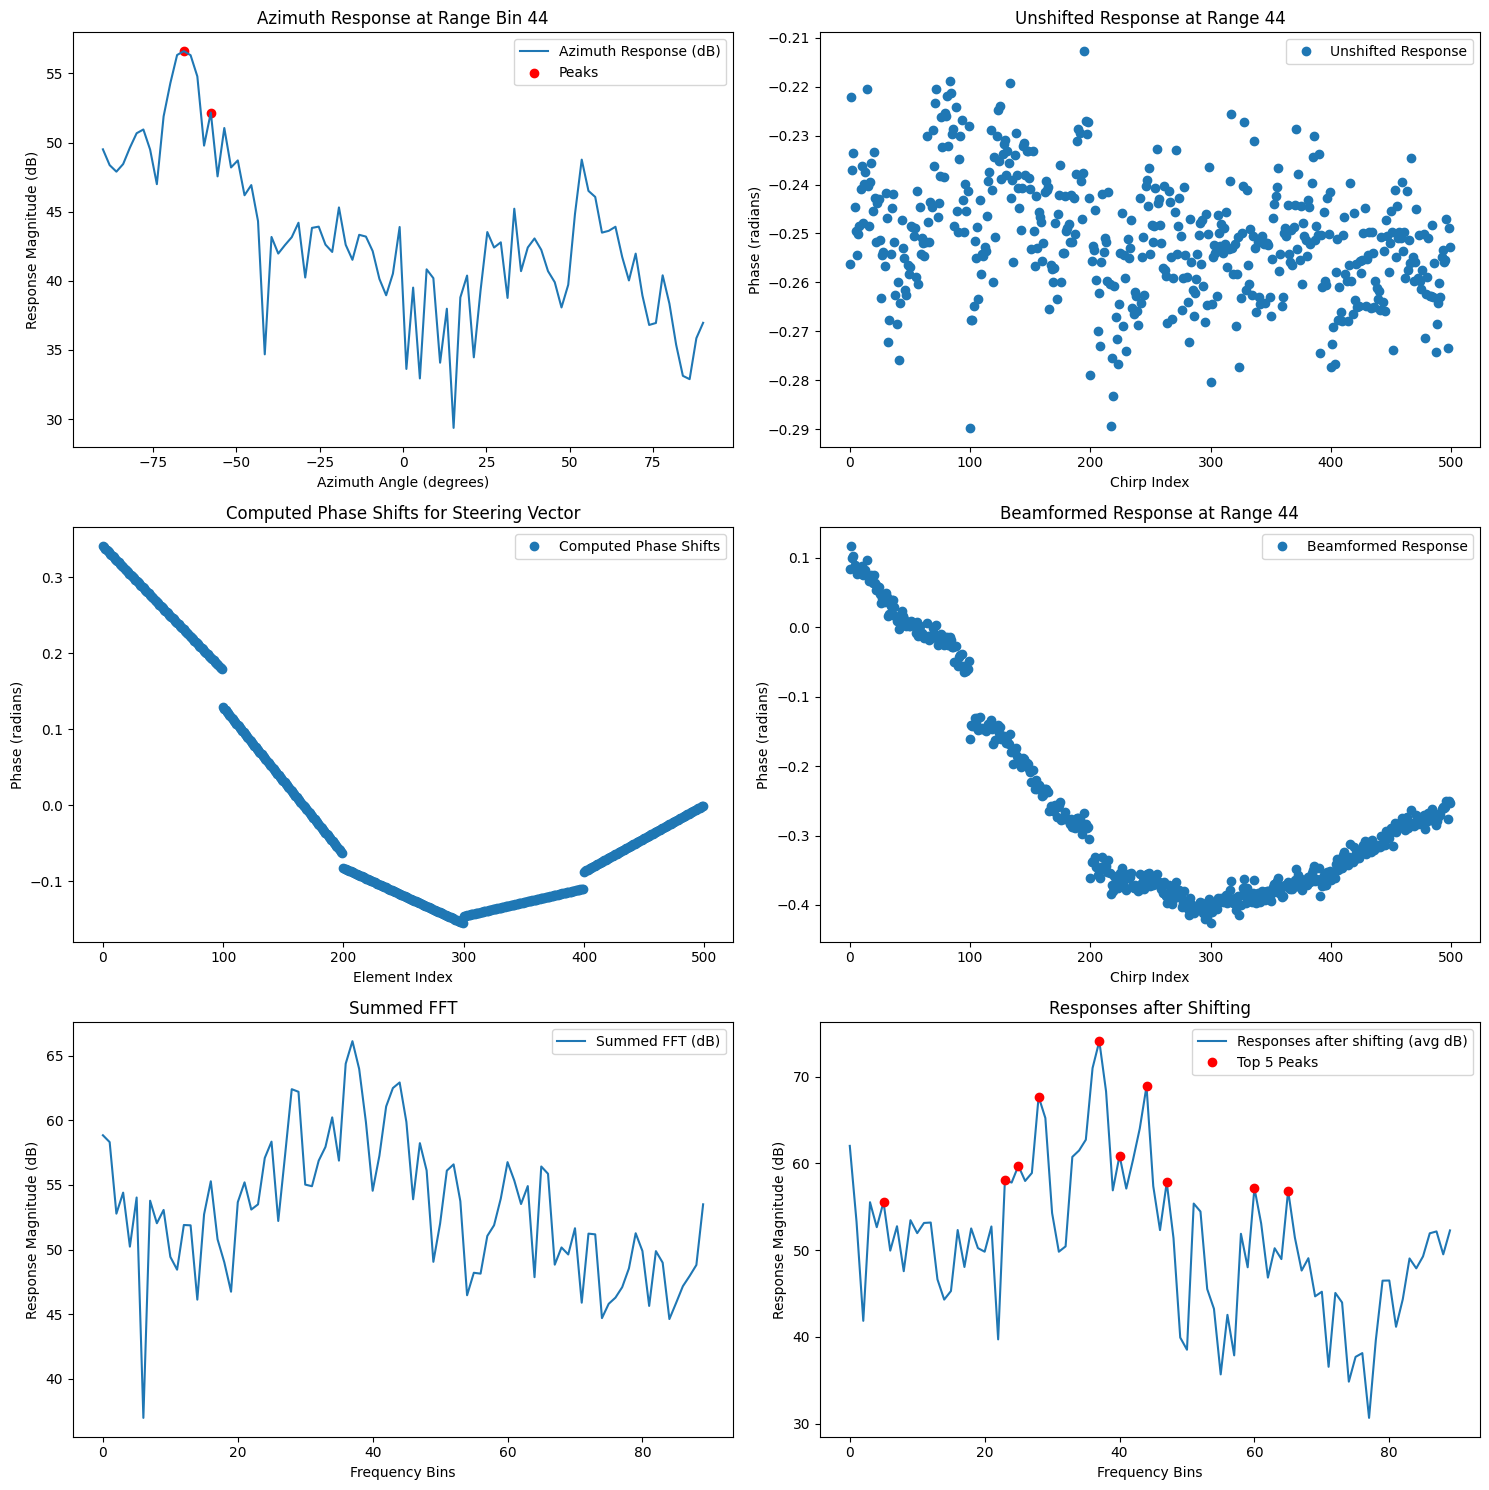

In [ ]:
from scipy.signal import find_peaks

#compute the az response at a specific range bin
rng_idx = sorted_peak_indices[1]
freq_resp_at_rng = 10 * np.log10(np.abs(processor.beamformed_resp[rng_idx, :, 0]))
az_angle_bins_deg = np.rad2deg(processor.az_angle_bins_rad)  # Convert azimuth angle bins to degrees

# Find the peaks in the response
peaks, _ = find_peaks(np.abs(freq_resp_at_rng), height=0)  # height=0 ensures we find all peaks
peak_values = np.abs(freq_resp_at_rng)[peaks]

# Sort the peaks by their values in descending order and get the top 2
az_peak_idxs = peaks[np.argsort(peak_values)[-2:][::-1]]
az_peak_vals = peak_values[np.argsort(peak_values)[-2:][::-1]]

print(f"Indices of the top 2 peaks: {az_peak_idxs}")
print(f"Values of the top 2 peaks: {az_peak_vals}")
print(f"Corresponding azimuth angles (degrees): {az_angle_bins_deg[az_peak_idxs]}")

#select the az steering angle from the max value
az_idx = az_peak_idxs[0]
el_idx = 0

#steering vector
steering_vector = processor.d[:,az_idx,el_idx]

#compute the phase shift to apply to each received signal
array_geometry_reshaped = \
    processor.array_geometry.transpose((1,0,2)).reshape(
        3,
        -1
    )
shifts = np.exp(
    1j * 2 * np.pi * \
    (steering_vector @ array_geometry_reshaped) / processor.lambda_m)
shifts = np.reshape(shifts,(1,shifts.shape[0]))
print(f"array geometry 1st element: {array_geometry_reshaped[:,-1]}")

#compute the beamformed response
beamformed_resps = np.multiply(adc_cube_reshaped,shifts)
beamformed_resp = np.sum(beamformed_resps,axis=1)

#compute the window
window = np.hanning(processor.num_range_bins)
beamformed_resp = np.fft.fft(window * beamformed_resp)

shifted_resps = np.multiply(freq_resps,shifts)


fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot 1: Azimuth Response at Range Bin
axs[0, 0].plot(az_angle_bins_deg, freq_resp_at_rng, label="Azimuth Response (dB)")
axs[0, 0].scatter(az_angle_bins_deg[az_peak_idxs], az_peak_vals, color='red', label="Peaks")
axs[0, 0].set_xlabel("Azimuth Angle (degrees)")
axs[0, 0].set_ylabel("Response Magnitude (dB)")
axs[0, 0].set_title("Azimuth Response at Range Bin {}".format(rng_idx))
axs[0, 0].legend()

# Plot 2: Unshifted Response at Range
axs[0, 1].plot(np.angle(freq_resps[rng_idx]), "o", label="Unshifted Response")
axs[0, 1].set_title("Unshifted Response at Range {}".format(rng_idx))
axs[0, 1].set_xlabel("Chirp Index")
axs[0, 1].set_ylabel("Phase (radians)")
axs[0, 1].legend()

# Plot 3: Shifts to apply
axs[1, 0].plot(np.angle(shifts[0,:]), "o", label="Computed Phase Shifts")
axs[1, 0].set_xlabel("Element Index")
axs[1, 0].set_ylabel("Phase (radians)")
axs[1, 0].set_title("Computed Phase Shifts for Steering Vector")
axs[1, 0].legend()

# # Plot 4: Beamformed Response at Range
axs[1, 1].plot(np.angle(shifted_resps[rng_idx]), "o", label="Beamformed Response")
axs[1, 1].set_title("Beamformed Response at Range {}".format(rng_idx))
axs[1, 1].set_xlabel("Chirp Index")
axs[1, 1].set_ylabel("Phase (radians)")
axs[1, 1].legend()

# Plot 5: Summed FFT (dB)
axs[2, 0].plot(10 * np.log10(np.abs(beamformed_resp)), label="Summed FFT (dB)")
axs[2, 0].set_title("Summed FFT")
axs[2, 0].set_xlabel("Frequency Bins")
axs[2, 0].set_ylabel("Response Magnitude (dB)")
axs[2, 0].legend()

# Plot 6: Responses after and before shifting
axs[2, 1].plot(avg_resp, label="Responses after shifting (avg dB)")
axs[2, 1].plot(sorted_peak_indices, sorted_peak_values, "ro", label="Top 5 Peaks")
axs[2, 1].set_title("Responses after Shifting")
axs[2, 1].set_xlabel("Frequency Bins")
axs[2, 1].set_ylabel("Response Magnitude (dB)")
axs[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Indices of the highest range peaks: [37 44 28 40 25 23 47 60 65  5]
(90, 500)
(90, 500)
(90, 500)
(90, 500)
(90, 500)


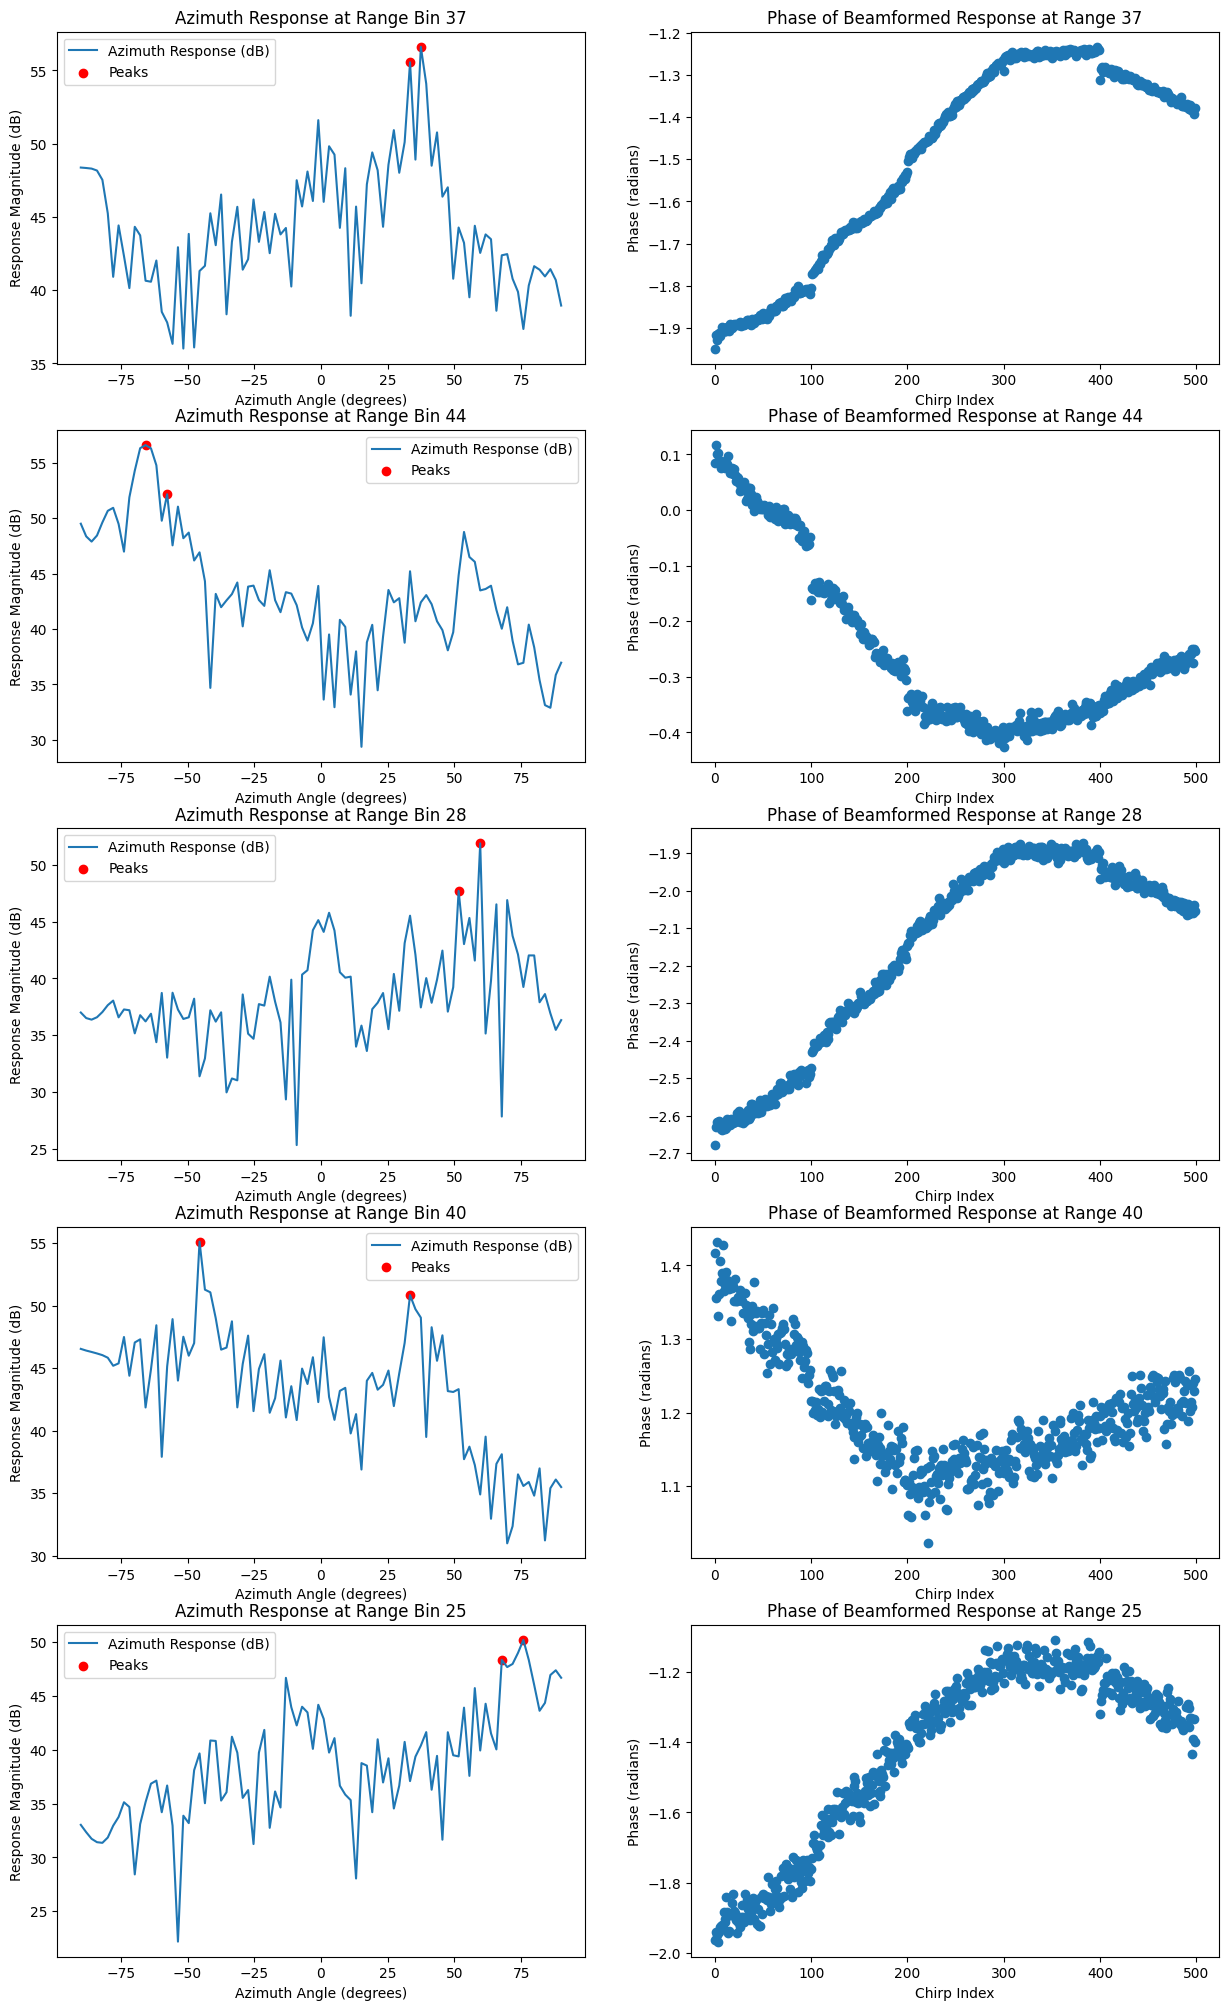

In [ ]:
#load the reshaped adc cube
adc_cube_reshaped = \
processor.history_acd_cube_valid_chirps.transpose((1,0,2)).reshape(
    processor.history_acd_cube_valid_chirps.shape[1], #number of samples per chirp
    -1
)

#compute the array geometry to apply
array_geometry_reshaped = \
    processor.array_geometry.transpose((1,0,2)).reshape(
        3,
        -1
    )

#compute the range ffts
window = np.hamming(adc_cube_reshaped.shape[1]).reshape(1, -1)
windowed_signal = window * adc_cube_reshaped
freq_resps = np.fft.fft(windowed_signal,axis=0)

#get the average response
avg_resp = np.mean(20 * np.log10(np.abs(freq_resps)), axis=1)

# Find the peaks range peaks using scipy
peak_indices, _ = find_peaks(avg_resp, height=0)  # height=0 ensures we find all peaks
peak_values = avg_resp[peak_indices]

# Sort the peaks by their values in descending order and get the top 5
sorted_rng_peak_idxs = peak_indices[np.argsort(peak_values)[-10:][::-1]]
print(f"Indices of the highest range peaks: {sorted_rng_peak_idxs}")

fig, axs = plt.subplots(5, 2, figsize=(15, 25))

for i in range(5):
    #compute the az response at a specific range bin
    rng_idx = sorted_rng_peak_idxs[i]
    freq_resp_at_rng = 10 * np.log10(np.abs(processor.beamformed_resp[rng_idx, :, 0]))
    az_angle_bins_deg = np.rad2deg(processor.az_angle_bins_rad)  # Convert azimuth angle bins to degrees

    # Find the peaks in the response
    peaks, _ = find_peaks(np.abs(freq_resp_at_rng), height=0)  # height=0 ensures we find all peaks
    peak_values = np.abs(freq_resp_at_rng)[peaks]

    # Sort the peaks by their values in descending order and get the top 2
    az_peak_idxs = peaks[np.argsort(peak_values)[-2:][::-1]]
    az_peak_vals = peak_values[np.argsort(peak_values)[-2:][::-1]]

    #select the az steering angle from the max value
    az_idx = az_peak_idxs[0]
    el_idx = 0

    #steering vector
    steering_vector = processor.d[:,az_idx,el_idx]

    #compute the phase shift to apply to each received signal
    shifts = np.exp(
        1j * 2 * np.pi * \
        (steering_vector @ array_geometry_reshaped) / processor.lambda_m)
    shifts = np.reshape(shifts,(1,shifts.shape[0]))

    print(freq_resps.shape)
    shifted_resps = np.multiply(freq_resps[rng_idx,:],shifts)[0]

    # Plot 1: Azimuth Response at Range Bin
    axs[i, 0].plot(az_angle_bins_deg, freq_resp_at_rng, label="Azimuth Response (dB)")
    axs[i, 0].scatter(az_angle_bins_deg[az_peak_idxs], az_peak_vals, color='red', label="Peaks")
    axs[i, 0].set_xlabel("Azimuth Angle (degrees)")
    axs[i, 0].set_ylabel("Response Magnitude (dB)")
    axs[i, 0].set_title("Azimuth Response at Range Bin {}".format(rng_idx))
    axs[i, 0].legend()

    # Plot 4: Beamformed Response at Range
    axs[i, 1].plot(np.unwrap(np.angle(shifted_resps)), "o", label="Beamformed Response")
    axs[i, 1].set_title("Phase of Beamformed Response at Range {}".format(rng_idx))
    axs[i, 1].set_xlabel("Chirp Index")
    axs[i, 1].set_ylabel("Phase (radians)")

In [ ]:
#load the reshaped adc cube
adc_cube_reshaped = \
processor.history_acd_cube_valid_chirps.transpose((1,0,2)).reshape(
    processor.history_acd_cube_valid_chirps.shape[1], #number of samples per chirp
    -1
)

#compute the array geometry to apply
array_geometry_reshaped = \
    processor.array_geometry.transpose((1,0,2)).reshape(
        3,
        -1
    )

#compute the range ffts
window = np.hamming(adc_cube_reshaped.shape[1]).reshape(1, -1)
windowed_signal = window * adc_cube_reshaped
freq_resps = np.fft.fft(windowed_signal,axis=0)

#get the average response
avg_resp = np.mean(20 * np.log10(np.abs(freq_resps)), axis=1)

# Find the peaks range peaks using scipy
peak_indices, _ = find_peaks(avg_resp, height=0)  # height=0 ensures we find all peaks
peak_values = avg_resp[peak_indices]

# Sort the peaks by their values in descending order and get the top 5
sorted_rng_peak_idxs = peak_indices[np.argsort(peak_values)[-15:][::-1]]
print(f"Indices of the highest range peaks: {sorted_rng_peak_idxs}")


target_phase_diffs = []
target_steering_vectors = []
for i in range(3):

    #compute the az response at a specific range bin
    rng_idx = sorted_rng_peak_idxs[i]
    freq_resp_at_rng = 10 * np.log10(np.abs(processor.beamformed_resp[rng_idx, :, 0]))
    az_angle_bins_deg = np.rad2deg(processor.az_angle_bins_rad)  # Convert azimuth angle bins to degrees

    # Find the peaks in the response
    peaks, _ = find_peaks(np.abs(freq_resp_at_rng), height=0)  # height=0 ensures we find all peaks
    peak_values = np.abs(freq_resp_at_rng)[peaks]

    # Sort the peaks by their values in descending order and get the top 2
    az_peak_idxs = peaks[np.argsort(peak_values)[-2:][::-1]]
    az_peak_vals = peak_values[np.argsort(peak_values)[-2:][::-1]]

    #select the az steering angle from the max value
    az_idx = az_peak_idxs[0]
    el_idx = 0

    #steering vector
    steering_vector = processor.d[:,az_idx,el_idx]

    #compute the phase shift to apply to each received signal
    shifts = np.exp(
        1j * 2 * np.pi * \
        (steering_vector @ array_geometry_reshaped) / processor.lambda_m)
    shifts = np.reshape(shifts,(1,shifts.shape[0]))

    shifted_resps = np.multiply(freq_resps[rng_idx,:],shifts)[0]

    #get the unwrapped phase
    unwrapped_phase = np.unwrap(np.angle(shifted_resps))

    #compute the phase differences
    phase_diffs = np.diff(unwrapped_phase,n=1)

    #append the phase diffs and steering vector
    target_phase_diffs.append(phase_diffs)
    target_steering_vectors.append(steering_vector)

target_phase_diffs = np.array(target_phase_diffs)
target_steering_vectors = np.array(target_steering_vectors)

print(f"target_phase_diffs shape: {target_phase_diffs.shape}")
print(f"target_steering_vectors shape: {target_steering_vectors.shape}")

array_geometry_corrections = np.zeros(shape=(2,target_phase_diffs.shape[1]))

for i in range(target_phase_diffs.shape[1]):

    Phi = target_phase_diffs[:, i]
    D_j = 2 * np.pi / processor.lambda_m * target_steering_vectors[:, 0:2]

    delta_p = np.linalg.lstsq(D_j, Phi, rcond=None)[0]
    
    array_geometry_corrections[:,i] = delta_p

absolute_corrections = np.cumsum(array_geometry_corrections,axis=1)

new_array_geometry = array_geometry_reshaped.copy()
new_array_geometry[0:2,1:] -= absolute_corrections



Indices of the highest range peaks: [37 44 28 40 25 23 47 60 65  5  3 51  9 12  7]
target_phase_diffs shape: (3, 499)
target_steering_vectors shape: (3, 3)


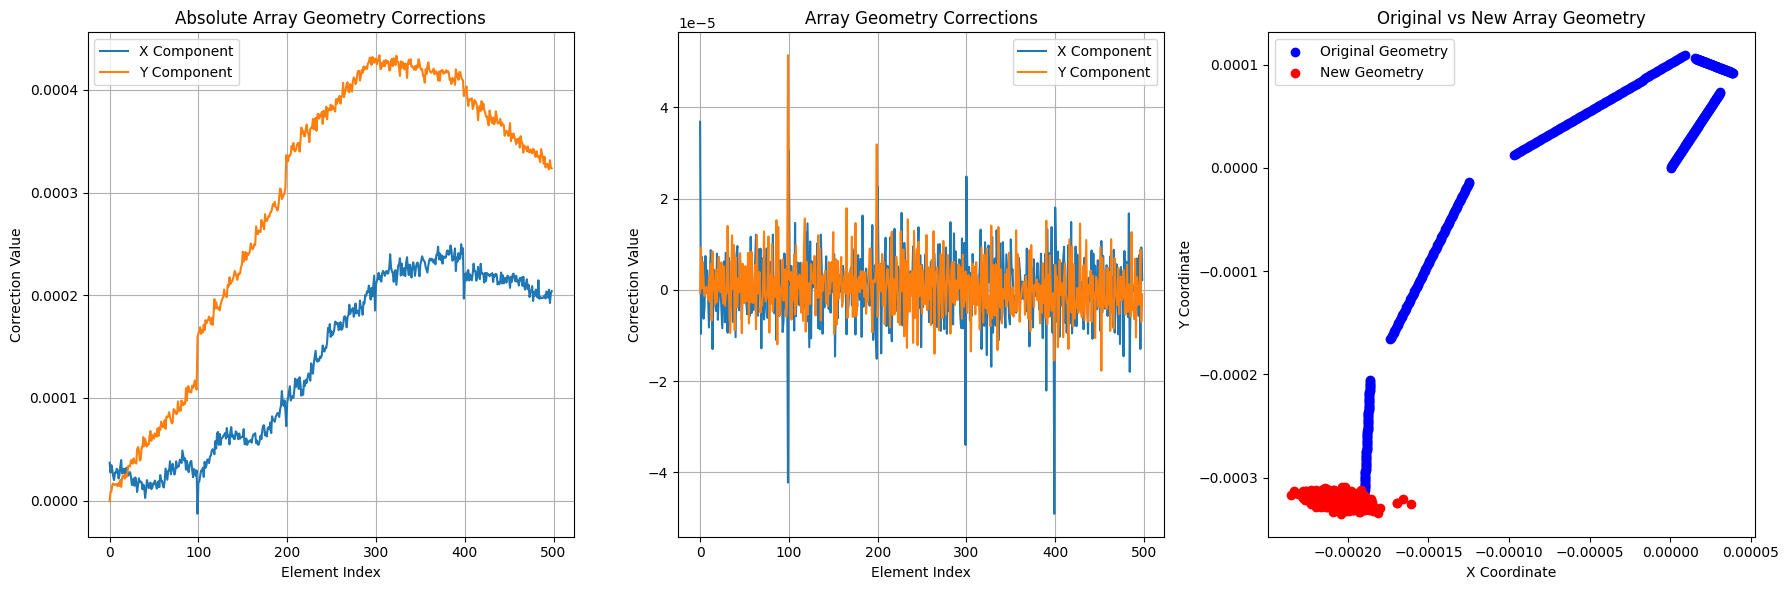

In [ ]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Absolute corrections (X and Y components)
axs[0].plot(absolute_corrections[0, :], label="X Component")
axs[0].plot(absolute_corrections[1, :], label="Y Component")
axs[0].set_title("Absolute Array Geometry Corrections")
axs[0].set_xlabel("Element Index")
axs[0].set_ylabel("Correction Value")
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Array geometry corrections (X and Y components)
axs[1].plot(array_geometry_corrections[0, :], label="X Component")
axs[1].plot(array_geometry_corrections[1, :], label="Y Component")
axs[1].set_title("Array Geometry Corrections")
axs[1].set_xlabel("Element Index")
axs[1].set_ylabel("Correction Value")
axs[1].legend()
axs[1].grid(True)

# Subplot 3: Scatter plot of original and new array geometry
axs[2].scatter(array_geometry_reshaped[0, :], array_geometry_reshaped[1, :], color='blue', label='Original Geometry')
axs[2].scatter(new_array_geometry[0, :], new_array_geometry[1, :], color='red', label='New Geometry')
axs[2].set_xlabel('X Coordinate')
axs[2].set_ylabel('Y Coordinate')
axs[2].set_title('Original vs New Array Geometry')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Indices of the highest range peaks: [37 44 28 40 25 23 47 60 65  5]


IndexError: index 0 is out of bounds for axis 0 with size 0

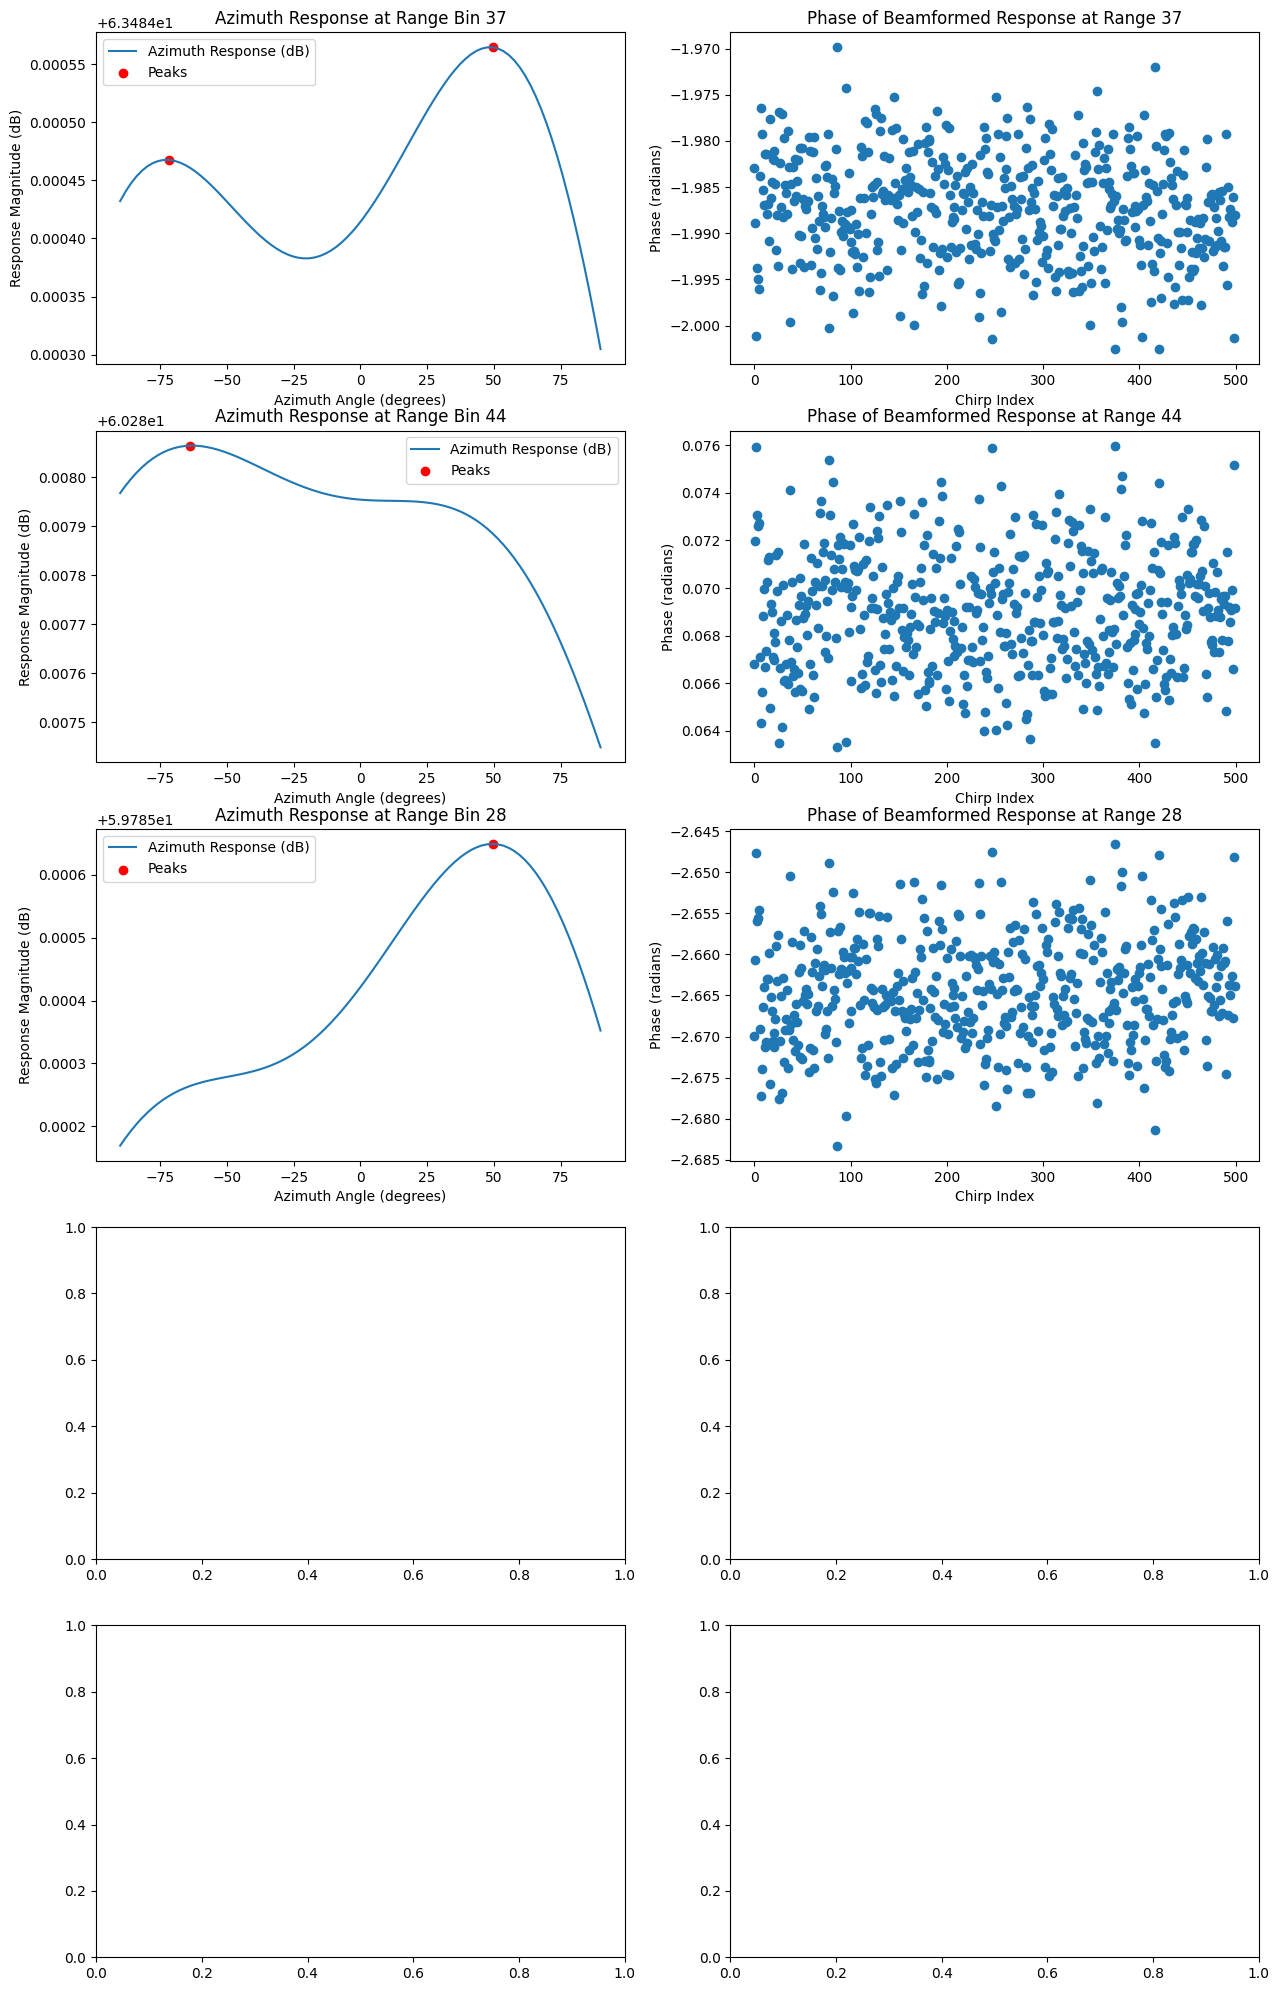

In [ ]:
#load the reshaped adc cube
adc_cube_reshaped = \
processor.history_acd_cube_valid_chirps.transpose((1,0,2)).reshape(
    processor.history_acd_cube_valid_chirps.shape[1], #number of samples per chirp
    -1
)

#compute the range ffts
window = np.hamming(adc_cube_reshaped.shape[1]).reshape(1, -1)
windowed_signal = window * adc_cube_reshaped
# windowed_signal = adc_cube_reshaped
freq_resps = np.fft.fft(windowed_signal,axis=0)

#compute the new beamformed response with the new geometry
beamformed_resp = np.zeros(
    shape=(processor.range_bins.shape[0],
            processor.az_angle_bins_rad.shape[0],
            processor.el_angle_bins_rad.shape[0]),
    dtype=complex
)

for az_angle_idx in range(processor.az_angle_bins_rad.shape[0]):
    for el_angle_idx in range(processor.el_angle_bins_rad.shape[0]):

        steering_vector = processor.d[:,az_angle_idx,el_angle_idx]

        # Get beamformed response at the steering angle
        resp = processor.compute_response_at_steering_angle(
            adc_cube=windowed_signal,
            array_geometry=new_array_geometry,
            steering_vector=steering_vector
        )

        # Save the response
        beamformed_resp[:,az_angle_idx,el_angle_idx] = resp

#get the average response
avg_resp = np.mean(20 * np.log10(np.abs(freq_resps)), axis=1)

# Find the peaks range peaks using scipy
peak_indices, _ = find_peaks(avg_resp, height=0)  # height=0 ensures we find all peaks
peak_values = avg_resp[peak_indices]

# Sort the peaks by their values in descending order and get the top 5
sorted_rng_peak_idxs = peak_indices[np.argsort(peak_values)[-10:][::-1]]
print(f"Indices of the highest range peaks: {sorted_rng_peak_idxs}")

fig, axs = plt.subplots(5, 2, figsize=(15, 25))

for i in range(5):
    #compute the az response at a specific range bin
    rng_idx = sorted_rng_peak_idxs[i]
    freq_resp_at_rng = 10 * np.log10(np.abs(beamformed_resp[rng_idx, :, 0]))
    az_angle_bins_deg = np.rad2deg(processor.az_angle_bins_rad)  # Convert azimuth angle bins to degrees

    # Find the peaks in the response
    peaks, _ = find_peaks(np.abs(freq_resp_at_rng), height=0)  # height=0 ensures we find all peaks
    peak_values = np.abs(freq_resp_at_rng)[peaks]

    # Sort the peaks by their values in descending order and get the top 2
    az_peak_idxs = peaks[np.argsort(peak_values)[-2:][::-1]]
    az_peak_vals = peak_values[np.argsort(peak_values)[-2:][::-1]]

    #select the az steering angle from the max value
    az_idx = az_peak_idxs[0]
    el_idx = 0

    #steering vector
    steering_vector = processor.d[:,az_idx,el_idx]

    #compute the phase shift to apply to each received signal
    shifts = np.exp(
        1j * 2 * np.pi * \
        (steering_vector @ new_array_geometry) / processor.lambda_m)
    shifts = np.reshape(shifts,(1,shifts.shape[0]))

    shifted_resps = np.multiply(freq_resps[rng_idx,:],shifts)[0]

    # Plot 1: Azimuth Response at Range Bin
    axs[i, 0].plot(az_angle_bins_deg, freq_resp_at_rng, label="Azimuth Response (dB)")
    axs[i, 0].scatter(az_angle_bins_deg[az_peak_idxs], az_peak_vals, color='red', label="Peaks")
    axs[i, 0].set_xlabel("Azimuth Angle (degrees)")
    axs[i, 0].set_ylabel("Response Magnitude (dB)")
    axs[i, 0].set_title("Azimuth Response at Range Bin {}".format(rng_idx))
    axs[i, 0].legend()

    # Plot 4: Beamformed Response at Range
    axs[i, 1].plot(np.unwrap(np.angle(shifted_resps)), "o", label="Beamformed Response")
    axs[i, 1].set_title("Phase of Beamformed Response at Range {}".format(rng_idx))
    axs[i, 1].set_xlabel("Chirp Index")
    axs[i, 1].set_ylabel("Phase (radians)")

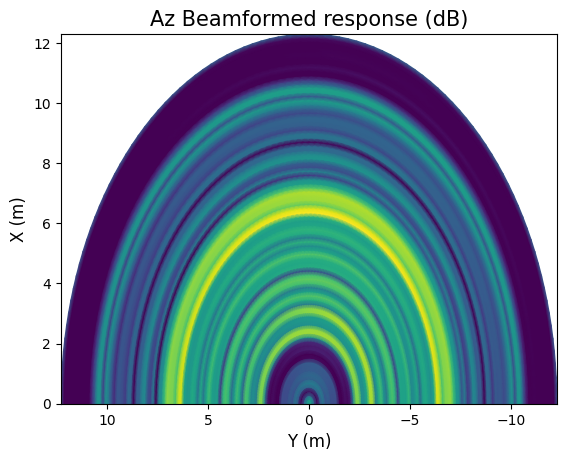

In [ ]:
synthetic_array_plotter.plot_2D_az_beamformed_resp_slice(
    resp=beamformed_resp,
    convert_to_dB=True,
    show=True,
)